<a id='top'></a>

# Homework 5: Confidence intervals and other things
***

**Name**:

***

This assignment is due on Moodle by **5 PM on Friday July 6**. Your solutions to theoretical questions should be done in Markdown/MathJax directly below the associated question.  Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  

**NOTES**: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function API **do not** change it.  If we do not provide a function API then you're free to structure your code however you like. 
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do Cell $\rightarrow$ Run All as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. 
- This should go without saying, but... For any question that asks you to calculate something, you **must show all work to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) | [Problem 4](#p4)

---

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import math

%matplotlib inline

# ---

<a id='p1'></a>
[Back to top](#top)

### [30 points] Problem 1 - Sea-level rise, schmee-level rise!

You have been contacted by the local government of Key West, Florida, to assess whether there is statistical evidence for sea-level rise in the area. You obtain from the University of Hawaii Sea Level Center's [gigantic repository of sea-level data](https://uhslc.soest.hawaii.edu/data/?rq) the daily mean sea levels file [linked here](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm0rl5dp6y4) and below.

In this problem, you will:
1. practice calculating confidence intervals, 
1. practice wrangling a real-life data set into a form where you can actually compute these confidence intervals, because life will rarely be so kind as to simply hand you a nicely packaged and cleaned set of data, and
1. save Key West from a watery fate?

In [7]:
# Local and web paths to the data; pick which works for you.
local_path = "data/sealevel_keywest.csv"
web_path   = "https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm0rl5dp6y4"
file_path  = web_path

dfSL = pd.read_csv(file_path, header=None)
dfSL.rename(columns={0 : 'Year', 1 : 'Month', 2 : 'Day', 3 : 'SL'}, inplace=True)
dfSL.head()

,Year,Month,Day,SL
0,1913,1,20,1453
1,1913,1,21,1439
2,1913,1,22,1444
3,1913,1,23,1489
4,1913,1,24,1474


**Part A:**  Write a function `clean_data` to:
1. take in a single argument of a raw sea level data frame (e.g., `dfSL` above),
2. compute the fill-value used to replace missing sea level (SL) data (**not** hard-coded!),
3. use the Pandas `DataFrame.dropna` method to remove all missing rows of data, 
4. select only the data point on the second day of each month, and
4. return a cleaned Pandas data frame.

Use your shiny new function to clean the `dfSL` data frame and save the results in a new data frame.

There is a very specific reason to sample only one daily data point per month. We will talk about it later.

In [8]:
def calc_fill(df):
    """
    Doing some plotting to figure out what the fill value is.
    """
    #ax = df.hist(column="SL", bins = 100)
    """
    Looks like it is a minimum in the data set. 
    """
    return df.min()["SL"]
    

def clean_data(df):
    fill = calc_fill(df)
    print("Fill value: {}".format(fill))
    df = df.replace(fill, np.nan)
    df = df.dropna()
    df = df[df["Day"] == 2]
    return df


dfClean = clean_data(dfSL)
dfClean.head()

Fill value: -32767


,Year,Month,Day,SL
13,1913,2,2,1409.0
41,1913,3,2,1397.0
72,1913,4,2,1402.0
102,1913,5,2,1450.0
133,1913,6,2,1490.0


My `clean_data` method first calculates the fill value. The fill value is -32767, a value far below the others in the data set and obtainable with the `min()` function. This was determined via visual inspection of a histogram of the data.



**Part B:**  Plot the cleaned time series of sea levels. Be sure to label your axes, including units. The UHSLC data portal includes a link to the metadata accompanying our data set; if you are not sure about units, that would be a good place to start looking. For the $x$-axis, place the $x$ tick marks on January 2 of each year that is divisible by 10 (i.e., 1920, 1930, ...), and label with that year. You may need to do additional processing in order to grab these indices. 

**Bonus challenge (0 points):**  Why did I choose to work with the second day of each month instead of the first?  You may need to look at the original data set to answer this.

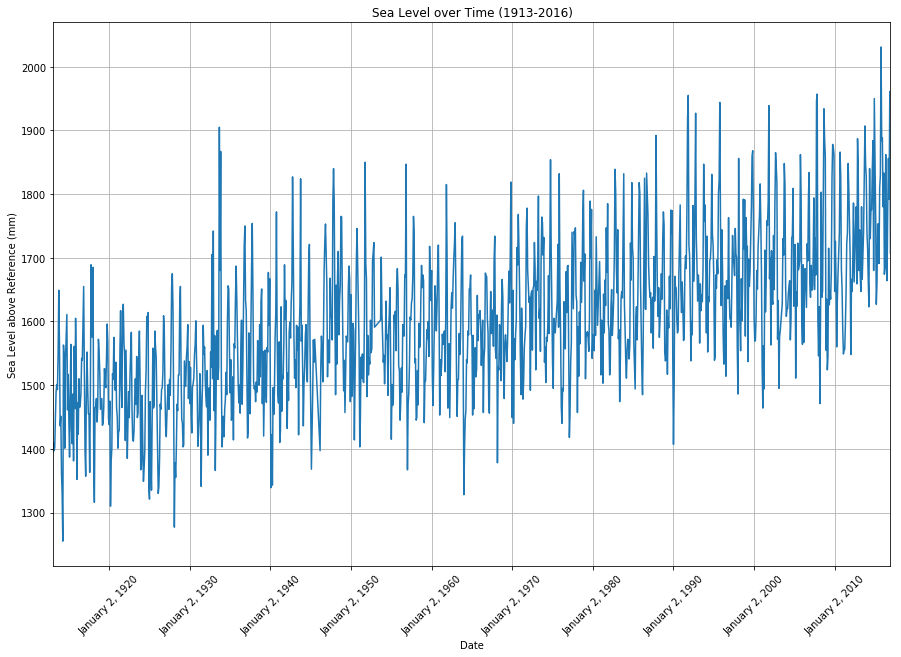

In [9]:
# Units are millimeters
ax = dfClean["SL"].plot.line(figsize=(15,10))
label_locs = []
labels = []
idx = 0
while idx < len(dfClean):
    item = dfClean.iloc[idx]
    if item["Year"] % 10 == 0 and item["Month"] == 1:
        label_locs.append(item.name) # Line plot is by Pandas index ok sure
        labels.append("January 2, " + str(int(item["Year"])))
    idx += 1
    
ax.set_xticks(label_locs);
ax.set_xticklabels(labels);
ax.grid();
ax.tick_params(axis='x', rotation=45);
ax.set_title("Sea Level over Time (1913-2016)");
ax.set_xlabel("Date");
ax.set_ylabel("Sea Level above Reference (mm)");

Indices for the second of January each year are grabbed with a loop over all elements. The second day of each month was choosen because the first of the year did not alway have data associated with it.

**Part C:** Use your cleaned sea levels data frame to create two new Pandas data frames or series:
1. one object to contain the sea levels between (and including) the years 1986 and 1995, and
2. another object to contain the sea levels between (and including) the years 2006 and 2015.

Then, create a single-panel figure that includes density histograms of each decade of sea levels. Be sure to label everything appropriately.

Finally, based on the data in front of you, formulate and state a hypothesis about how the mean sea level in the decade 2006-2015 compares to the mean sea level in the decade 1986-1995.

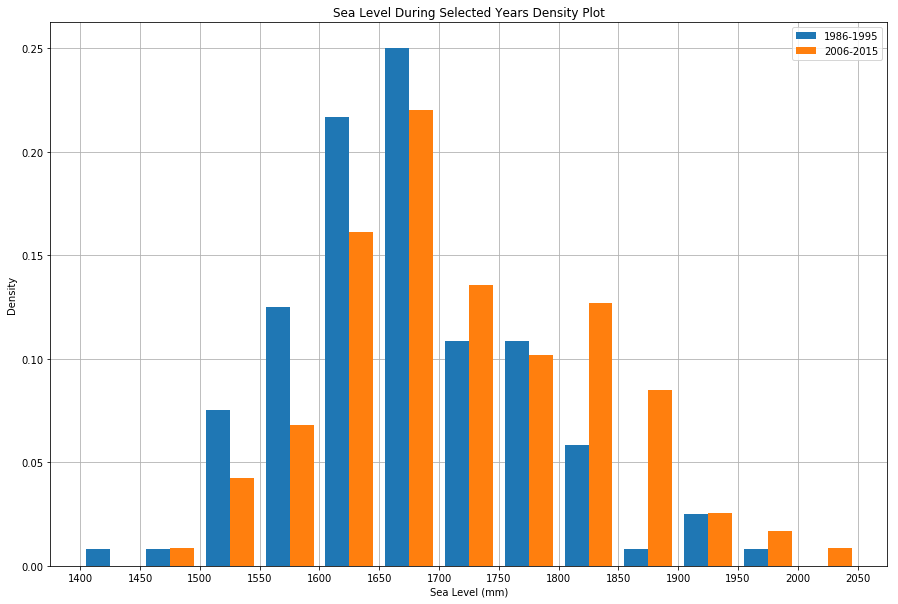

In [10]:
def tanner_flavored_histogram(data_arr, lower, upper, bin_width, density=True, fwidth=1, \
                              legend_labels=(), xlabel='x', ylabel='Frequency', title='Histogram'):
    """
    I really don't like the default histogram plotting so I made a better version.
    
    data_arr: vector of data sets you wish to plot.
    lower: lower bound to plot
    upper: upper bound to plot
    bin_width: width of each bin
    density: make it a density plot or nah
    fwidth: width that the bars take up within a bin
    legend_labels: legend bits
    
    The rest is self explanatory
    
    """
    plt.figure(figsize=(15,10))
    n_bins = int((upper-lower)/bin_width)
    
    nelem = np.shape(data_arr)[0]
    for elem in range(0, nelem):
        data = data_arr[elem]
        hist, edges = np.histogram(data, bins=n_bins, range=(lower,upper))
        histd = hist
        if density:
            histd = hist/np.sum(hist)
            
        left_edges = edges[:(len(edges)-1)]
        filled_width = bin_width * fwidth
        individual_width = filled_width/nelem
        bins = left_edges + (bin_width-filled_width/2) + individual_width*elem
        
        plt.bar(bins, histd, width=individual_width, align='edge')
        
    plt.legend(legend_labels)
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(edges+bin_width/2, edges.astype('int').astype('str'))
    plt.xlim((lower,upper))
    plt.show();


# Selection
dfMillenials = dfClean.loc[dfClean["Year"] >= 1986]
dfMillenials = dfMillenials.loc[dfMillenials["Year"] <= 1995]

dfGenZ = dfClean.loc[dfClean["Year"] >= 2006]
dfGenZ = dfGenZ.loc[dfGenZ["Year"] <= 2015]

arrMillenials = dfMillenials["SL"].values
arrGenZ = dfGenZ["SL"].values    

# Plotting
a = [arrMillenials, arrGenZ]

tanner_flavored_histogram(a, 1400, 2100, 50, density=True, fwidth=0.8, \
                          legend_labels=("1986-1995","2006-2015"),  \
                          xlabel='Sea Level (mm)', ylabel='Density', \
                          title='Sea Level During Selected Years Density Plot');

I hypothesize that the mean sea level in the time between 2006 and 2015 was higher than the mean sea level between 1986 and 1995. The null hypothesis to this alternative is that there is no difference between the sea levels.

To explain the code above, I first select the sea levels from the proper years and save the values into arrays. Then I pass the data to a custom histogram function of mine that handles the plotting.

**Part D:** Compute a 99.9% confidence interval for each of (1) the mean sea level in the 1986-1995 decade ($\mu_{1986-1995}$) and (2) the mean sea level in the 2006-2015 decade ($\mu_{2006-2015}$).  You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

Based on these two confidence intervals, do you think there is sufficient evidence to conclude that there is or is not a significant difference in the mean sea level between 1986-1995 and 2006-2015? Justify your answer. 

To find the 99.9% confidence intervals for the mean sea level in each time range, a few parameters are needed. First, a critical value for $z_{\alpha / 2}$ is calculated using `scipy.stats.norm.ppf()`. We want the value critical value such that 99.95% of the area of the graph is left of $z_{\alpha / 2}$. This value turns out to be 3.291.

Then, the means of each time period are calculated, $\mu_{1986-1995}$ and $\mu_{2006-2015}$. These values are 1,670 mm and 1,720 mm, respectively. 

Next, the number of elements in each date range are computed, $n$ and $m$, corresponding to 1986-1995 and 2006-2015, respectively. There are 120 elements in the former range, and 118 in the latter. 

Third, variances for each range are computed with one degree of freedom. The variances for each decade are 9,703 mm$^2$ and 12,062 mm$^2$. 

Finally, the confidence intervals are calculated with the following formulas:

$$
\begin{equation*}
    \bar{x}_{1986-1995} - z_{\alpha / 2} \sqrt{\frac{\sigma_{1986-1995}^2}{n}} \leq \mu_{1986-1995} \leq \bar{x}_{1986-1995} + z_{\alpha / 2} \sqrt{\frac{\sigma_{1986-1995}^2}{n}} \\
    \bar{x}_{2006-2015} - z_{\alpha / 2} \sqrt{\frac{\sigma_{2006-2015}^2}{m}} \leq \mu_{2006-2015} \leq \bar{x}_{2006-2015} + z_{\alpha / 2} \sqrt{\frac{\sigma_{2006-2015}^2}{m}}
\end{equation*}
$$

The confidence intervals end up being [1640.985, 1700.165] mm and [1687.409, 1753.947] mm. Since they overlap, I do not think there is sufficient evidence from these calculations to conclude that there is a significant difference in sea level.

In [45]:
alpha = 0.999
z_alpha2 = stats.norm.ppf(alpha + (1-alpha)/2)

print("z: {:0.3f}".format(z_alpha2))

millenialMean = arrMillenials.mean()
genZMean = arrGenZ.mean()

print("Means: {0:0.3f}, {1:0.3f}".format(millenialMean, genZMean))

nMillenials = len(arrMillenials)
nGenZ = len(arrGenZ)

print("Counts: {0:0.3f}, {1:0.3f}".format(nMillenials, nGenZ))

millenialVar = arrMillenials.var(ddof=1)
genZVar = arrGenZ.var(ddof=1)

print("Variances: {0:0.3f}, {1:0.3f}".format(millenialVar, genZVar))

ciMillenial = z_alpha2*math.sqrt(millenialVar/nMillenials)
ciGenZ = z_alpha2*math.sqrt(genZVar/nGenZ)
print("{0:0.3f} CI for 1986-1995: [{1:0.3f}, {2:0.3f}]".format(alpha, millenialMean - ciMillenial, \
                                                               millenialMean + ciMillenial))
print("{0:0.3f} CI for 2006-2015: [{1:0.3f}, {2:0.3f}]".format(alpha, genZMean - ciGenZ, \
                                                               genZMean + ciGenZ))

z: 3.291
Means: 1670.575, 1720.678
Counts: 120.000, 118.000
Variances: 9703.440, 12062.494
0.999 CI for 1986-1995: [1640.985, 1700.165]
0.999 CI for 2006-2015: [1687.409, 1753.947]


**Part E:**  Compute a 99.9% confidence interval for the ***difference in mean sea level*** between the 2006-2015 and the 1986-1995 decades ($\mu_{2006-2015} - \mu_{1986-1995}$. Based on this, make a conclusion regarding your hypothesis from **Part C**, and compare to what your results in **Part D** implied. You may use Python for arithmetic operations and executing the calculations, but the relevant steps/set-up should be displayed in Markdown/MathJax.

Very similar calulcations are carried out for this part as in Part D. The only differences are the confidence interval is for the difference between the means $\mu_{1986-1995} - \mu_{2006-2015}$ and that the term with the square root incorporates variances from both date ranges. The full expression is below.

$$
\begin{equation*}
    \bar{y} - z_{\alpha / 2} \sqrt{\frac{\sigma_{1986-1995}^2}{n} + \frac{\sigma_{1986-1995}^2}{n}} \leq \delta \leq \bar{y} + z_{\alpha / 2} \sqrt{\frac{\sigma_{1986-1995}^2}{n} + \frac{\sigma_{1986-1995}^2}{n}}
\end{equation*} \\ 
    \bar{y} = \bar{x}_{1986-1995} - \bar{x}_{2006-2015} \\
    \delta = \mu_{1986-1995} - \mu_{2006-2015}
$$

In [33]:
y_bar = abs(millenialMean - genZMean)
ci = z_alpha2 * math.sqrt(millenialVar/nMillenials + genZVar/nGenZ)
print("{0:0.3f} CI for difference between means: [{1:0.3f}, {2:0.3f}]".format(alpha, y_bar - ci, y_bar + ci))

0.999 CI for difference between means: [5.579, 94.627]


Based on these calculations, we can be 99.9% certain that the difference in the mean sea level in the two date ranges is between 5.579 mm and 94.627 mm. Because this interval does not include zero, we fail to reject the null hypothesis proposed in Part C that there is no change in sea level. Additionally, this provides evidence in addition to the calculations done in Part D that do allow for consideration of the alternative hypothesis. In Part D, since the CIs for the means overlapped, no conclusion could be drawn. The differences in the means done here, however, tell a different story.

**Part F:**  The confidence intervals from **Parts D** and **E** were derived using the Central Limit Theorem.  Which assumption of the Central Limit Theorem would likely be violated if we took more than one measurement per month to form our samples, and why?

The assumption that samples were independent may be violated if more than one sample was taken. This is because within a month, cycles such as the moon's orbit, tides, weather, etc. may influence the sea level and correlate samples. Then, the CLT could not be deployed.

---

<a id='p2'></a>
[Back to top](#top)

### [25 points] Problem 2 - Quality of Red vs White Wine 

**Part A:** Load the data in [`winequalityred.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm1ebc6q6ye) and [`winequalitywhite.csv`](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm17x9pu6y9) into Pandas DataFrames.  They are available under Resources on Piazza, and linked here and below.  A description of this dataset can be found on [UC Irvine's Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine+Quality). The quantity of interest for this problem is the quality of the wine.

Are we justified in using the Central Limit Theorem in our analysis of estimates of the mean and proportions of the data?  Justify your response. 

In [36]:
# read either local or web file version; pick whichever works for you
local_file_white = "../../data/winequalitywhite.csv"
local_file_red   = "../../data/winequalityred.csv"
web_file_white = "https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm17x9pu6y9"
web_file_red   = "https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jixzm1ebc6q6ye"

dfRed   = pd.read_csv(web_file_red, sep=';')
dfWhite = pd.read_csv(web_file_white, sep=';')

dfRed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Yes it is justified to use the CLT because we can assume that the quality of each wine does not affect the quality of the others when tasted. In addition, wines are sampled from the same distribution (wines of northern Portugal). Therefore, CLT applies because random samples are independent and identically distributed.

**Part B:** Let $X$ be a random variable denoting the quality of a bottle of wine, and let $C$ be a random variable denoting its color (either red ($r$) or white ($w$)). For the remainder of this problem, we are concerned with probabilities such as "If I buy a random bottle of red wine, what is the probability that its quality is at least a 7?". We could write that probability as $P(X \geq 7 \mid C=r)$, for example, and consider it the ***proportion*** of the population of red wines that are at least a 7 in quality. Calculate and report estimates of $P(X \geq 7 \mid C=r)$ and $P(X \geq 7 \mid C=w)$.

Obtain 95% confidence intervals for the proportion of red and white wines that are **at least** a 7 in quality (obtain one CI for each color).  Based on your results, if you are interested in buying many high quality bottles of wine but are buying totally at random, is one color a better bet than the other? Fully justify your answer.

Calculations may be executed in Python, but you need to set up your work (*what* it is you are calculating) in Markdown/MathJax.

The first step is to isolate the proportion of wines which have a quality of seven or more for each color. 

In [65]:
dfGoodRed = dfRed.loc[dfRed["quality"] >= 7]
dfGoodWhite = dfWhite.loc[dfWhite["quality"] >= 7]

nr = len(dfRed)
nw = len(dfWhite)

print("Counts: {0:0.3f}, {1:0.3f}".format(nr, nw))

pRed = len(dfGoodRed)/nr
pWhite = len(dfGoodWhite)/nw

print("Proportion of red wine with quality >= 7: {:0.3f}".format(pRed))
print("Proportion of white wine with quality >= 7: {:0.3f}".format(pWhite))

Counts: 1599.000, 4898.000
Proportion of red wine with quality >= 7: 0.136
Proportion of white wine with quality >= 7: 0.216


So, we estimate $P(X \geq 7 \, | \, C = r) \approx 0.136$ and $P(X \geq 7 \, | \, C = w) \approx 0.216$.

Now, we calculate the variance in the proportion estimator.

In [66]:
vRed = (pRed*(1-pRed))/nr
vWhite = (pWhite*(1-pWhite))/nw

print("Variance of red wine with quality >= 7: {:0.3e}".format(vRed))
print("Variance of white wine with quality >= 7: {:0.3e}".format(vWhite))

Variance of red wine with quality >= 7: 7.335e-05
Variance of white wine with quality >= 7: 3.462e-05


Finally, we find the critical value for the 95% confidence interval.

In [67]:
alpha = 0.95
z_alpha2 = stats.norm.ppf(alpha + (1-alpha)/2)

print("Critical Value: {:0.3f}".format(z_alpha2))

Critical Value: 1.960


Now, we can calculate the confidence interval itself.

In [68]:
ciRed = [pRed - z_alpha2 * math.sqrt(vRed), pRed + z_alpha2 * math.sqrt(vRed)]
ciWhite = [pWhite - z_alpha2 * math.sqrt(vWhite), pWhite + z_alpha2 * math.sqrt(vWhite)]

print("{0:0.3f} CI for red wine quality: [{1:0.4f}, {2:0.4f}]".format(alpha, ciRed[0], ciRed[1]))
print("{0:0.3f} CI for white wine quality: [{1:0.4f}, {2:0.4f}]".format(alpha, ciWhite[0], ciWhite[1]))

0.950 CI for red wine quality: [0.1189, 0.1525]
0.950 CI for white wine quality: [0.2049, 0.2279]


Based on these confidence intervals, it is reasonable to conclude that if one is interested in buying high-quality wines at random, they should purchase white wines. The white wines have a higher proportion of high-quality wines and the confidence intervals for the proportions of high quality wines for each color does not come close to overlapping at the 95% confidence level.

**Part C:** Now, as college students (and teachers), we might not be super concerned with buying a really high quality bottle of wine.  In fact, you might be confused about what these "bottles" this problem is referring to are... don't we mean "bags"?  But I digress.  Let's focus instead on making sure we do *not* buy a really disgusting bottle of wine.  Calculate and report estimates of $P(X \geq 5 \mid C=r)$ and $P(X \geq 5 \mid C=w)$.

Obtain two 95% confidence intervals, one for the proportion of red wines and one for white wines, that are **at least** a 5 in quality, that is, $P(X \geq 5 \mid C)$.  Based on your results - and what you saw in Problem 1 - if you are interested in buying bottles of wine that are at least a 5 in quality, but are again buying wine totally randomly, can you conclude that you are better off buying one color over the other? Fully justify your answer.

The first step is to aggresively deploy CTRL+C and CTRL+V from Part B. The same calculations are carried out but now wines with a quality greater than or equal to 5 are isolated.

In [69]:
dfGoodRed = dfRed.loc[dfRed["quality"] >= 5]
dfGoodWhite = dfWhite.loc[dfWhite["quality"] >= 5]

nr = len(dfRed)
nw = len(dfWhite)

print("Counts: {0:0.3f}, {1:0.3f}".format(nr, nw))

pRed = len(dfGoodRed)/nr
pWhite = len(dfGoodWhite)/nw

print("Proportion of red wine with quality >= 5: {:0.3f}".format(pRed))
print("Proportion of white wine with quality >= 5: {:0.3f}".format(pWhite))

vRed = (pRed*(1-pRed))/nr
vWhite = (pWhite*(1-pWhite))/nw

print("Variance of red wine with quality >= 5: {:0.3e}".format(vRed))
print("Variance of white wine with quality >= 5: {:0.3e}".format(vWhite))

alpha = 0.95
z_alpha2 = stats.norm.ppf(alpha + (1-alpha)/2)

print("Critical Value: {:0.3f}".format(z_alpha2))

ciRed = [pRed - z_alpha2 * math.sqrt(vRed), pRed + z_alpha2 * math.sqrt(vRed)]
ciWhite = [pWhite - z_alpha2 * math.sqrt(vWhite), pWhite + z_alpha2 * math.sqrt(vWhite)]

print("{0:0.3f} CI for red wine quality: [{1:0.4f}, {2:0.4f}]".format(alpha, ciRed[0], ciRed[1]))
print("{0:0.3f} CI for white wine quality: [{1:0.4f}, {2:0.4f}]".format(alpha, ciWhite[0], ciWhite[1]))

Counts: 1599.000, 4898.000
Proportion of red wine with quality >= 5: 0.961
Proportion of white wine with quality >= 5: 0.963
Variance of red wine with quality >= 5: 2.367e-05
Variance of white wine with quality >= 5: 7.343e-06
Critical Value: 1.960
0.950 CI for red wine quality: [0.9511, 0.9701]
0.950 CI for white wine quality: [0.9573, 0.9679]


Here we see that the proportion of of wines with a quality greater than or equal to 5 is approximately independent of color, about 96% of wines of either color had that quality or better. Specifically, the proportion of red wine with a quality $\geq$5 is 0.961 and 0.963 for white.

Interestingly, the confidence intervals for the proportion of each wine color with a quality $\geq$5 overlap ([0.9511, 0.9701] for red and [0.9573, 0.9679] for white), so we cannot conclude that it is better to by one over another. Rather, we can only determine with 95% certainty that the proportion of wines with a quality $\geq$5 is within those intervals for each color.

**Part D:** Compute a 95% confidence interval for the difference in proportions of red and white wines that are at least a 5 in quality. 

Now, based on your results for this part, can you conclude that you are better off buying one color over the other? Fully justify your answer. How does your work here differ from your work in **Part C**?

In [71]:
pDiff = abs(pRed - pWhite)
scale = z_alpha2 * math.sqrt(vRed + vWhite)
ci = [pDiff - scale, pDiff + scale]
print("{0:0.3f} CI for difference in quality: [{1:0.4f}, {2:0.4f}]".format(alpha, ci[0], ci[1]))

0.950 CI for difference in quality: [-0.0089, 0.0130]


The resulting confidence interval from computing the difference in proportions of $\geq$5 quality wine between the wine colors agrees with Part C. We cannot conclude that it is better to buy one color over another because the 95% confidence interval includes zero, so there may be no difference.

The work here is difference from Part C because it concerns the difference in proportions itself rather than each proportion individually. This allows for a more rigorous comparison between populations.

**Part E:**  Now, we have many more observations of white wines than red. This certainly contributes to the width of the 95% confidence interval for the proportion of red wines that are at least a 5 in quality, which you should have found in **Part C** to be wider than the corresponding confidence interval for white wines. 

How large would our sample size of red wines need to be in order to guarantee that this 95% confidence interval width is at most 0.01? Note that we are hypothetically adding more samples, so we do not know the precise value of $\hat{p}$.

The above problem can be expressed with the following inequality that compares the width of the confidence interval and the maximum width

$$
2 z_{\alpha/2} \sqrt{\frac{p(1-p)}{n}} \leq 0.01
$$

We know the value for $z_{\alpha/2}$ and also that the max value for $p(1-p)$ is 0.25 at $p=0.5$. These facts allow the calculation of the maxmimum number of samples to have a CI width of 0.01.

$$
2 z_{\alpha/2} \sqrt{\frac{p(1-p)}{n}} \leq 0.01 \qquad \implies \qquad n \approx 38,416 \, \text{samples}
$$

The real value will likely be much lower since it is unlikely that the sample proportion would change significantly given more samples. Assuming it does not change significantly from $\hat{p}_{quality\,red}$, the above can be recalculated to about 5,759 samples for the red wine to have a CI width less than or equal to 0.01.

---

<a id='p3'></a>
[Back to top](#top)

### [15 points] Problem 3:  Are you tired of re-doing the same confidence intervals calculation over and over again? Then this is the problem for you!

Turns out, the mechanics of computing confidence intervals are fairly formulaic, once you get the hang of it.  If you have done the first two problems, I would say with 99% confidence that you are tired of copy-pasting code and putting in new data frames and numbers. So let's develop some flexible, generic software to do this for us. Yay computers!

In order to test drive our software, we will use the [weather data set](https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jhzhwu02pxq4eq) from the in-class notebooks back in the beginning of the semester (and linked here).  Execute the code cell below to load the data, print out the valid site names, and view the first few lines, including the column headers.

In [74]:
# Two different paths to the data 
local_path = 'data/clean_boulder_weather.csv'
web_path   = 'https://piazza.com/class_profile/get_resource/jhaqogsdelf76h/jhzhwu02pxq4eq'

# Select the path that works for you 
file_path = web_path 

# Load the data into a DataFrame 
df = pd.read_csv(file_path)

# View the site names
print("Site names are:",set(df["NAME"]))

df.head()

Site names are: {'RALSTON RESERVOIR, CO US', 'BOULDER 14 W, CO US', 'NORTHGLENN, CO US', 'GROSS RESERVOIR, CO US', 'BOULDER, CO US', 'NIWOT, CO US', 'SUGARLOAF COLORADO, CO US'}


,STATION,NAME,DATE,PRCP,TMAX,TMIN
0,USW00094075,"BOULDER 14 W, CO US",2017-07-01,0.00,68.0,31.0
1,USW00094075,"BOULDER 14 W, CO US",2017-07-02,0.00,73.0,35.0
2,USW00094075,"BOULDER 14 W, CO US",2017-07-03,0.00,68.0,46.0
3,USW00094075,"BOULDER 14 W, CO US",2017-07-04,0.05,68.0,43.0
4,USW00094075,"BOULDER 14 W, CO US",2017-07-05,0.01,73.0,40.0


**Your task:** Write a function called `ci_mean` with the following specifications.  You are **NOT** allowed to use this function for Problems 1 and 2, but are encouraged to use it to check your answers. You may use this function for Problem 4.

**Code Specifications:**

Arguments:
* `x` -- A list, numpy array, or Pandas DataSeries ("array-like object") that constitutes the data we want a confidence interval for the mean of its population, $\mu_x$.
* `y` -- An optional argument with a default of `None`. Also an array-like object. If `y` is specified, then the function should return a confidence interval for the difference in means, $\mu_x - \mu_y$.
* `sx` -- An optional argument with a default of `None`. If specified, `sx` is the true known standard deviation of the population of `x`.
* `sy` -- An optional argument with a default of `None`. If specified, `sy` is the true known standard deviation of the population of `y`. If `sy` is specified but `y` is not, your code should proceed with computing a confidence interval for the mean of the `x` population only.
* `alp` -- Tail area for the confidence interval (i.e., you want to calculate a $100(1-\textrm{alp})\%$ confidence interval). Should have a default value of $0.05$.

Output:
* `CI` -- A tuple giving the lower and upper confidence bounds for the $100(1-\textrm{alp})\%$ confidence interval.

Required Output: show us output for the following
* For NIWOT, CO US, use your `ci_mean` function to construct a 90% confidence interval for the mean July 2017 maximum temperatures, $\mu_{niwot}$.
* For BOULDER 14 W, CO US, use your `ci_mean` function to construct a 90% confidence interval for the mean July 2017 maximum temperatures, $\mu_{boulder14}$. Based on your answers so far, can you conclude anything at the 90% confidence level about any differences in mean July 2017 daily maximum temperature in Niwot and Boulder 14 W?
* Use your `ci_mean` function to compute a 90% confidence interval for the difference in mean July 2017 daily maximum temperature between NIWOT and BOULDER 14 W, $\mu_{niwot} - \mu_{boulder14}$. Can you conclude anything, at the 90% confidence level, about the difference in mean daily maximum temperature in July for the two sites?

Unit Tests: not required, but encouraged
* Check your answers to Problems 1 and 2.
* Check your answers for the Required Output by hand.
* Crowd-source some unit tests:  Check your answers for other combinations of the weather data sites and confidence levels with your peers on Piazza!
* There is sizable probability that we will use other test cases to grade your code, including possibly other problems from this homework, and other sets of data. So your code must **not** be hard-coded to expect input from the weather data set.

In [84]:
def ci_mean(x, y=None, sx=None, sy=None, alp=0.05):
    xbar = np.mean(x)
    n = np.shape(x)[0]
    var = xbar
    
    xvar = 0
    if sx is not None:
        xvar = sx
    else:
        xvar = np.var(x, ddof=1)
    
    z = stats.norm.ppf(1-alp/2)
    
    scale = 0
    if y is not None:
        ybar = np.mean(y)
        m = np.shape(y)[0]
        yvar = 0
        if sy is not None:
            yvar = sy
        else:
            yvar = np.var(y, ddof=1)
        
        var = abs(xbar-ybar)
        scale = z*math.sqrt(xvar/n + yvar/m)
    else:
        scale = z*math.sqrt(xvar/n)
        
    return (var - scale, var + scale)


julyNiwot = df[(df["NAME"] == 'NIWOT, CO US') & (df["DATE"] >= '2017-07-01') & (df["DATE"] <= '2017-07-31')]
ciNiwot = ci_mean(julyNiwot["TMAX"], alp=0.1)
print("Niwot CI: ({0:0.3f}, {1:0.3f})".format(ciNiwot[0], ciNiwot[1]))
julyBoulder = df[(df["NAME"] == 'BOULDER 14 W, CO US') & (df["DATE"] >= '2017-07-01') & (df["DATE"] <= '2017-07-31')]
ciBoulder = ci_mean(julyBoulder["TMAX"], alp=0.1)
print("Boulder CI: ({0:0.3f}, {1:0.3f})".format(ciBoulder[0], ciBoulder[1]))

Niwot CI: (68.178, 71.500)
Boulder CI: (67.209, 70.404)


Based on these calculations at the 90% confidence level we cannot conclude that the temperatures are difference because the confidence intervals overlap.

In [85]:
ciDiff = ci_mean(x=julyNiwot["TMAX"], y=julyBoulder["TMAX"], alp=0.1)
print("CI of temperature difference: ({0:0.3f}, {1:0.3f})".format(ciDiff[0], ciDiff[1]))

CI of temperature difference: (-1.272, 3.336)


The same conclusion is reached when computing the difference. The confidence interval for the difference in temperatures includes zero, so we cannot reject the null hypothesis that there is no difference in temperature.

---

<a id='p4'></a>
[Back to top](#top)

### [30 points] Problem 4 - Exploring Confidence Intervals 

The [Gumbel](https://en.wikipedia.org/wiki/Gumbel_distribution) distribution is one of several distributions frequently used to model environmental extremes (for example, extreme temperatures and sea levels).  It is also fairly asymmetric, and thus interesting for investigating confidence intervals.  It is implemented in scipy.stats as [gumbel_r](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gumbel_r.html), where the appendix "\_r" denotes the right-skewed version of the Gumbel distribution (as opposed to the left-skewed).

**Part A**: Complete the following code cell to plot a histogram of 1,000 realizations from the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  Be sure to leave this cell executed before turning in your assignment!

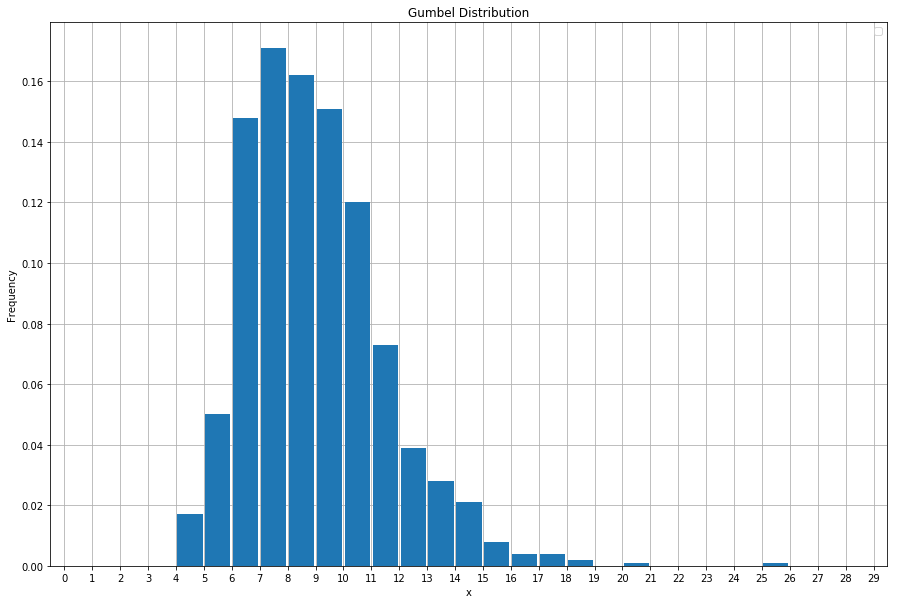

In [95]:
mu = 8
beta = 2
n_sample = 1000
x = stats.gumbel_r.rvs(loc=mu, scale=beta, size=n_sample)

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,4))

# Deploy the function I made in problem 1.
tanner_flavored_histogram([x], 0, 30, 1, density=True, fwidth=0.9, xlabel='x', ylabel='Frequency', title='Gumbel Distribution')

**Part B:** Look up the analytical mean and variance of the Gumbel distribution with parameters $\mu=8$ and $\beta=2$ and calculate them here by hand.  Note that the Euler–Mascheroni constant can be accessed via `np.euler_gamma`. 

Use the empirical mean from your sample in **Part A**, and the true variance of the Gumbel distribution to compute by hand a 95% confidence interval for the mean.  Feel free to use your code from **Problem 3** here!

The mean and variance are given by

$$
\begin{align*}
    \mu &= \alpha + \gamma \beta \\
    \sigma^2 &= \frac{1}{6} \pi^2 \beta^2
\end{align*}
$$

where $\gamma$ is the Euler-Mascheroni constant and $\alpha$ is the location parameter.

So, the mean is

In [102]:
mu_ana = mu + np.euler_gamma * beta
print(mu_ana)

9.154431329803066


And the variance is

In [103]:
var_ana = (1/6) * np.pi**2 * beta**2
print(var_ana)

6.579736267392905


In [105]:
gumbel_ci = ci_mean(x, sx=var_ana, alp=0.05)
print("Gumbel CI: [{0:0.3f}, {1:0.3f}]".format(gumbel_ci[0], gumbel_ci[1]))

Gumbel CI: [8.857, 9.175]


A 95% confidence interval for the mean of the Gumbel distribution is [8.857, 9.175].

**Part C:  A theoretical interlude.** When I ran my solution code for **Part B**, I obtained a 95% confidence interval of $[8.81, 9.82]$ for the mean of the $Gum(\mu=8, \beta=2)$ distribution. For each of the following, explain why or why not the situation described is correct, given the technical definition of a 95% confidence interval we went over in class.

**(i)** If you had no other evidence regarding true mean of the $Gum(\mu=8, \beta=2)$ distribution, you could say there is a 95% chance that its true mean falls between 8.81 and 9.82.

**(ii)** If a class of 100 students all construct 95% confidence intervals for the mean of the $Gum(\mu=8, \beta=2)$ distribution, then we expect about 95 of their CIs to contain the true mean, and about 5 of them to miss the true mean.

**(iii)** There is a 95% probability that any given random variable sampled from $Gum(\mu=8, \beta=2)$ will be between 8.81 and 9.82.

(i) Incorrect because 95% confidence interval means that 95% of generated confidence intervals would contain the mean, not that there is a 95% chance that the interval contains the mean.

(ii) Correct because a 95% confidence interval implies that 95% of generated confidence intervals from random draws from a distribution will contain the true mean.

(iii) Incorrect, this is a statement about the CDF of a probability distribution.

**Part D:** In this part you'll write a function to investigate the _coverage properties_ of a confidence interval for the mean of the Gumbel distribution. Complete the following function to randomly sample $m=500$ sample means with sample size $n=100$ for the Gumbel distribution with parameters $\mu=8$ and $\beta=2$.  For each random sample, compute the 95% confidence interval for the mean.  Note that you actually know that the variance for the true population distribution is, $\sigma^2$.  Your function should do two things: 

1. Report the proportion of confidence intervals that successfully cover the true mean of the distribution 
2. Make a plot of 50 randomly selected confidence intervals. Overlay the intervals on the line $y=\textrm{True mean}$ (from **Part B**). Color confidence intervals black if they cover the true mean, and red if they don't.  

Be sure to leave this cell executed before turning in your assignment!

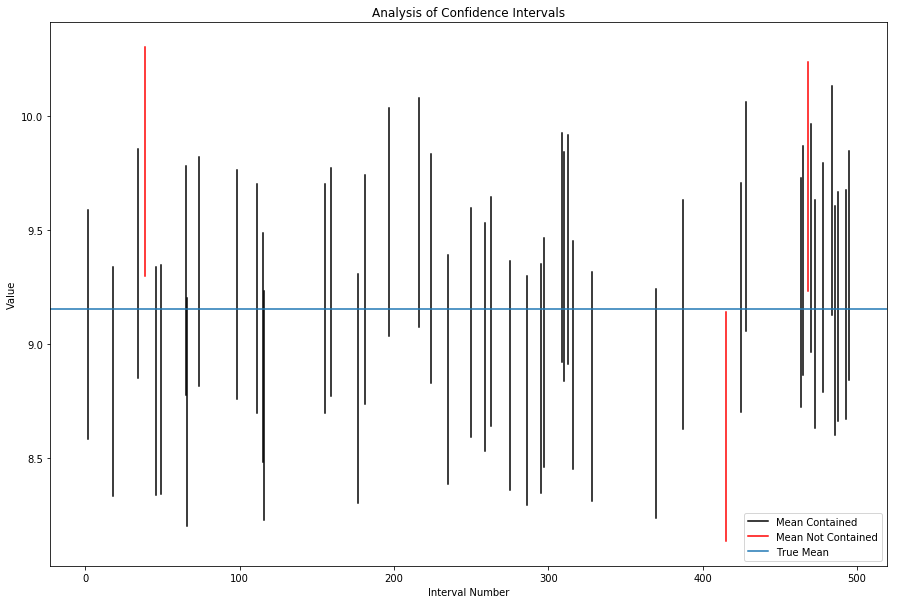

Number of intervals containing mean: 474


In [133]:
def interval_contains(x, ci):
    return (x >= ci[0]) and (x <= ci[1])


def confidence_intervals(m=500, n=100):
    mu = 8
    beta = 2

    plt.figure(figsize=(15,10))
    cis = np.zeros((m,3))
    plot_me = np.random.randint(0,m,size=50)
    lred = False
    lblack = False
    for i in range(0,m):
        x = stats.gumbel_r.rvs(loc=mu, scale=beta, size=n)
        gumbel_ci = ci_mean(x, sx=var_ana, alp=0.05)
        cis[i,:] = [gumbel_ci[0], gumbel_ci[1], interval_contains(mu_ana, gumbel_ci)]
        if i in plot_me:
            c = 'k' if cis[i,2] else 'r'
            if c == 'k' and not lblack:
                plt.plot([i,i],[cis[i,0], cis[i,1]], c, label="Mean Contained")
                lblack = True
            elif c == 'r' and not lred:
                plt.plot([i,i],[cis[i,0], cis[i,1]], c, label="Mean Not Contained")
                lred = True
            else:
                plt.plot([i,i],[cis[i,0], cis[i,1]], c)
    
    plt.axhline(mu_ana, label="True Mean")
    plt.legend()
    plt.title("Analysis of Confidence Intervals")
    plt.ylabel('Value')
    plt.xlabel("Interval Number")
    plt.show()
    print("Number of intervals containing mean: {}".format(np.count_nonzero(cis[:,2])))
    

confidence_intervals()

474 of 500 intervals contain the mean.

**Part E:** Does the proportion of confidence intervals that cover the true mean of the distribution agree with the theory described in class?  Justify your conclusion. 

The proportion of confidence intervals that cover the true mean agrees with what we discussed in class because 95% of 500 is 475. This is very close to what was empirically observed here. In addition, it is predicted out of 50 intervals, 2 or 3 will not contain the mean. This is observed in the plot above.

**Part F**: In general, which is wider: a 95% confidence interval or a 99% confidence interval? Now, ELIF.  That is, *Explain it Like I'm Five*.

A 99% confidence interval is wider because it expresses a higher certainty that a measure is within the given interval, which can be achieved by making it wider. 

Imagine you played a fun game of kickball with your friends at recess today and you are telling your parents about it. You had an awesome kick way into the outfield, but you aren't exactly sure where it landed. Like a good kid, however, you want to tell the truth about the game. If you tell your parents a bigger area where it might have landed, like a bigger confidence interval, there is a higher change you are telling the truth. Plus, if you go around to your other friends with the same idea then you can be sure you are telling the truth about the game more often then not.